In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/phd-code/topic-models

In [2]:
%cd /content/drive/MyDrive/postdoc-work/sophia\'s materials/topic-models

/content/drive/MyDrive/postdoc-work/sophia's materials/topic-models


In [7]:
def vocab(data_url):
  """process data input."""
  data = []
  i2w = {}
  fin = open(data_url)
  while True:
    line = fin.readline()
    if not line:
      break
    word_freqs = line.split()
    index = len(data)
    data.append(word_freqs[0])
    i2w[index] = word_freqs[0]

  fin.close()
  return i2w

voc = vocab('data/20news/vocab.new')
len(voc)

2000

In [8]:
# check words most associated with latent dims
import torch
import pickle

def get_topk_top(fname, top_k):
  with open(fname, "rb") as f:
  # with open(f"weights_900_{type}.pkl", "rb") as f:
    weights = pickle.load(f)
  all_topic_list = []
  for t in range(50):
      words = torch.topk(weights, top_k, 0)[1][:,t]
      topic_list = []
      for w in words:
          i2w = voc[w.item()]
          topic_list.append(i2w)
      # print(topic_list)
      all_topic_list.append(topic_list)
  return all_topic_list

In [9]:
!pip install sentence-transformers

In [10]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
# load model
model = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
# compute topic similarity
def compute_topic_similarity(topic):
    # get embeddings for each word in the topic
    embeddings = model.encode(topic)
    # compute pairwise cosine similarity
    similarities = cosine_similarity(embeddings)
    # return the average of the upper triangular matrix (excluding the diagonal)
    return np.mean(similarities[np.triu_indices_from(similarities, k=1)])

# process and rank topics based on similarity
def process_and_rank_topics(topic_list, list_name, verbose=1):
    # compute similarities for all topics
    topic_similarities = [compute_topic_similarity(topic) for topic in topic_list]

    # rank topics by similarity
    ranked_topics = sorted(zip(topic_list, topic_similarities), key=lambda x: x[1], reverse=True)

    # print the top-scoring topics
    if verbose:
      print(f"\n=== {list_name} Ranked Topics ===")
      for i, (topic, score) in enumerate(ranked_topics):
          print(f"Rank {i+1} (Score: {score:.4f}): {topic}")

    # return the average similarity for the entire list
    return np.mean(topic_similarities)


In [13]:
!pwd

/content/drive/MyDrive/postdoc-work/sophia's materials/topic-models


In [14]:
import glob


softmax = {k:[] for k in [5, 10, 20, 50]}
entmax = {k:[] for k in [5, 10, 20, 50]}
for top_k in [5, 10, 20, 50]:
  for fname in glob.glob("experiments_final/*"):
    topic_list = get_topk_top(f"{fname}/weights_400.pkl", top_k)
    # process and rank both soft_topic_list and ent_topic_list
    avg_similarity = process_and_rank_topics(topic_list, "Topics", verbose=False)
    if "softmax" in fname:
      softmax[top_k].append(avg_similarity)
    else:
      entmax[top_k].append(avg_similarity)

In [15]:
import pandas as pd
top_k_values = [5, 10, 20, 50]

# Convert data into a DataFrame for easier plotting with Seaborn
data = []
for k in top_k_values:
    data.append([k, np.mean(softmax[k]), np.std(softmax[k]), 'NVDM'])
    data.append([k, np.mean(entmax[k]), np.std(entmax[k]), 'FY VAE'])

df = pd.DataFrame(data, columns=['Top-k', 'Coherence', 'Std', 'Method'])


In [17]:
df.to_csv("topic_scores.csv")

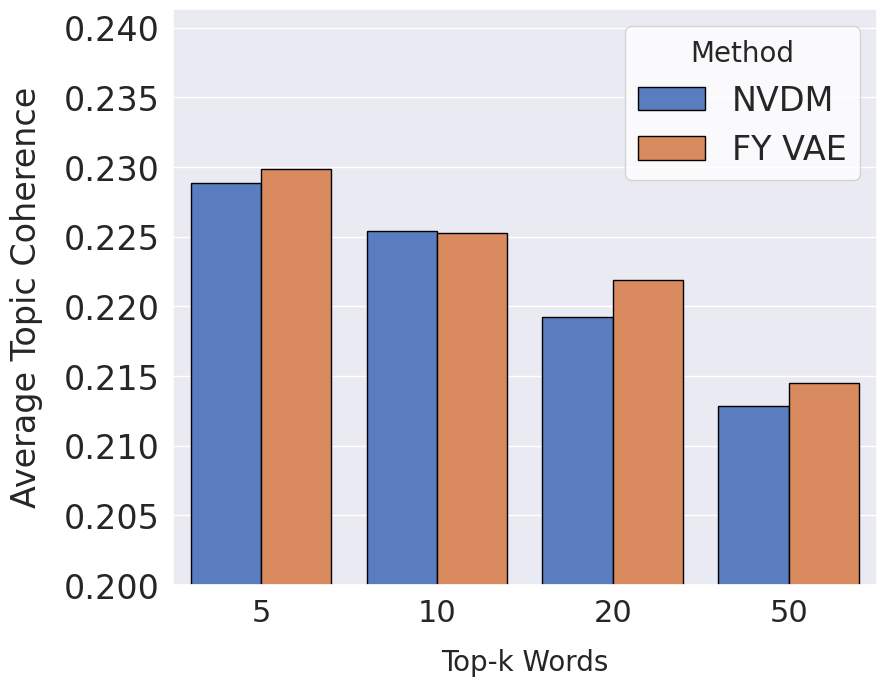

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import font_manager

df = pd.read_csv("topic_scores.csv")

# Set style and context
sns.set_style("ticks", rc={"patch.force_edgecolor": True, "patch.edgecolor": "black"})
sns.set_context("notebook", font_scale=2)  # Increase font scale for readability

# Create the figure and axis
plt.figure(figsize=(10, 8))

# Bar plot with enhanced settings
with sns.axes_style("darkgrid"):
    sns.barplot(x='Top-k', y='Coherence', hue='Method', data=df, errorbar=None, capsize=0.2, err_kws={'linewidth': 2},palette='muted', edgecolor='black')

# Customize labels and ticks
plt.xlabel('Top-k Words', fontsize=20, labelpad=15)
plt.ylabel('Average Topic Coherence', fontsize=24, labelpad=15)
plt.legend(loc='upper right', fontsize=24, title='Method', title_fontsize='20')  # Adjust legend size
# plt.xticks(ticks=plt.xticks()[0], ha='right', fontsize=24, rotation=45)  # Rotate and increase font size
plt.yticks(fontsize=24)
plt.ylim(0.2, None)

# Save the plot with tight layout and padding
plt.tight_layout(pad=2)
plt.savefig('coherence.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
